In [30]:
from elasticsearch import Elasticsearch, RequestError, TransportError
import json
import multiprocessing
import numpy as np
import os
import pandas as pd
import time
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Set current working directory
os.chdir("../cord_19_dataset")
os.getcwd()

'/home/nrs/SideProjects/COVID19_Research_Analysis/cord_19_dataset'

**Regular-Ass Pandas Dataframes**

In [3]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_df = pd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)

In [59]:
metadata_df = metadata_df.dropna(subset=["title"], how="all")
metadata_df = metadata_df.fillna("")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
doc_embeddings = tfidf_vectorizer.fit_transform(metadata_df["title"])
print(f"Embeddings type: {type(doc_embeddings)}")
print(f"pd.Series embedding shape: {doc_embeddings.shape}")

Embeddings type: <class 'scipy.sparse.csr.csr_matrix'>
pd.Series embedding shape: (379790, 98354)


**Dask Dataframes**<br>
How to use Dask to deal with dataframes that don't fit in memory? We'll find out here.

Dask is a parallel computing library (one machine or distributed) that offers abstractions to **work with numpy and pandas datasets larger than a single machine's memory through parallel computation**. Numpy, pandas, and sklearn were not designed to scale beyond a single CPU or its machine's memory. Dask solves this problem by becoming a platform to build distributed data applications. <br>

Dask parallelizes computation via partitions. Dask dataframes are made up of many panda dataframes (i.e. partition), loaded lazily and in parallel. A single method call or computation on a Dask dataframe makes many pandas method calls in parallel. This also allows the programmer to interact with Dask dataframes larger than memory, so long as each partition fits into memory. Furthermore, Dask dataframes are *lazily loaded*, meaning that operations on a Dask dataframe builds up a task (computation) graph. <br>

Thus, Dask's power comes from running intensive computations on large out-of-memory datasets in parallel with a small memory footprint.

Breaking Dask down simply, we have two components: <br>
1. **High-Level Collections:** Dask provides high-level data structures that mimic Numpy and Pandas, but can operate on datasets that don't fit into main memory in parallel. Basically, they're alternative to Numpy and Pandas for large datasets.  
2. **Low-Level Schedulers:** Dask provides dynamic task schedulers that execute task DAGs in parallel. These execution engines power computations on the above high-level collections. They allow for fast computations on out-of-memory datasets with a minimal memory footprint. Basically, they're alternatives to multiprocessing and multithreading and other task scheduling systems like Luigi.   

In [4]:
import dask.dataframe as dd
from dask.distributed import Client

num_cpu_cores = multiprocessing.cpu_count()
client = Client(n_workers=num_cpu_cores)  # Set to number of cores of machine
client.cluster

In [5]:
from time import sleep

def inc(x):
    # sleep(1)
    return x + 1

def add(x, y):
    # sleep(1)
    return x + y

In [6]:
%%time
from dask import delayed

# This runs immediately, all it does is build a graph
# delayed(computation_func_name)(param_0, param_1, ...) where params can also be dask.Delayed objects

x = delayed(inc)(1)  # Computation graph with one node
y = delayed(inc)(2)  # Computation graph with one node
z = delayed(add)(x, y)  # Computation graph with three nodes

CPU times: user 0 ns, sys: 1.49 ms, total: 1.49 ms
Wall time: 1.2 ms


CPU times: user 62.5 ms, sys: 63.8 ms, total: 126 ms
Wall time: 304 ms


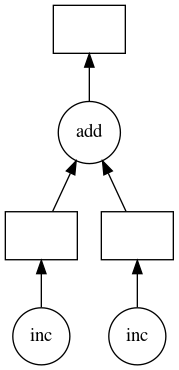

In [7]:
%%time

x.visualize()
# z = lazy dask.Delayed object (computation graph)
# z.compute() passes computation graph into an execution engine 
# (which parallelizes workload with minimal memory footprint), 
# yielding actual result of computation
z.compute() 
z.visualize()  # Visualize computation graph

**Parallelizing Computations using Dask**

Before computing: Delayed('sum-d6688992-79fb-420d-96c6-49d7a094177f')
After computing : 44
CPU times: user 49.8 ms, sys: 34.5 ms, total: 84.3 ms
Wall time: 149 ms


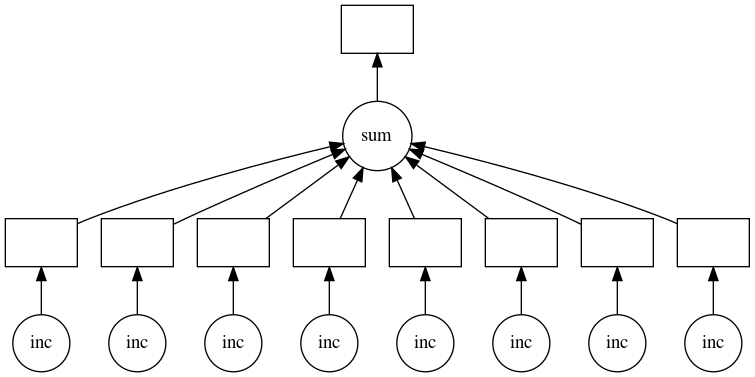

In [8]:
%%time

data = [1, 2, 3, 4, 5, 6, 7, 8]
results = []

for x in data:
    y = delayed(inc)(x)  # Reminder: doesn't actually perform computation here
    results.append(y)  # Add dask.Delayed object to list

# Params = list of dask.Delayed objects, total = dask.Delayed object (contains computation DAG)
# No actual computation performed below; just building the computation DAG!
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

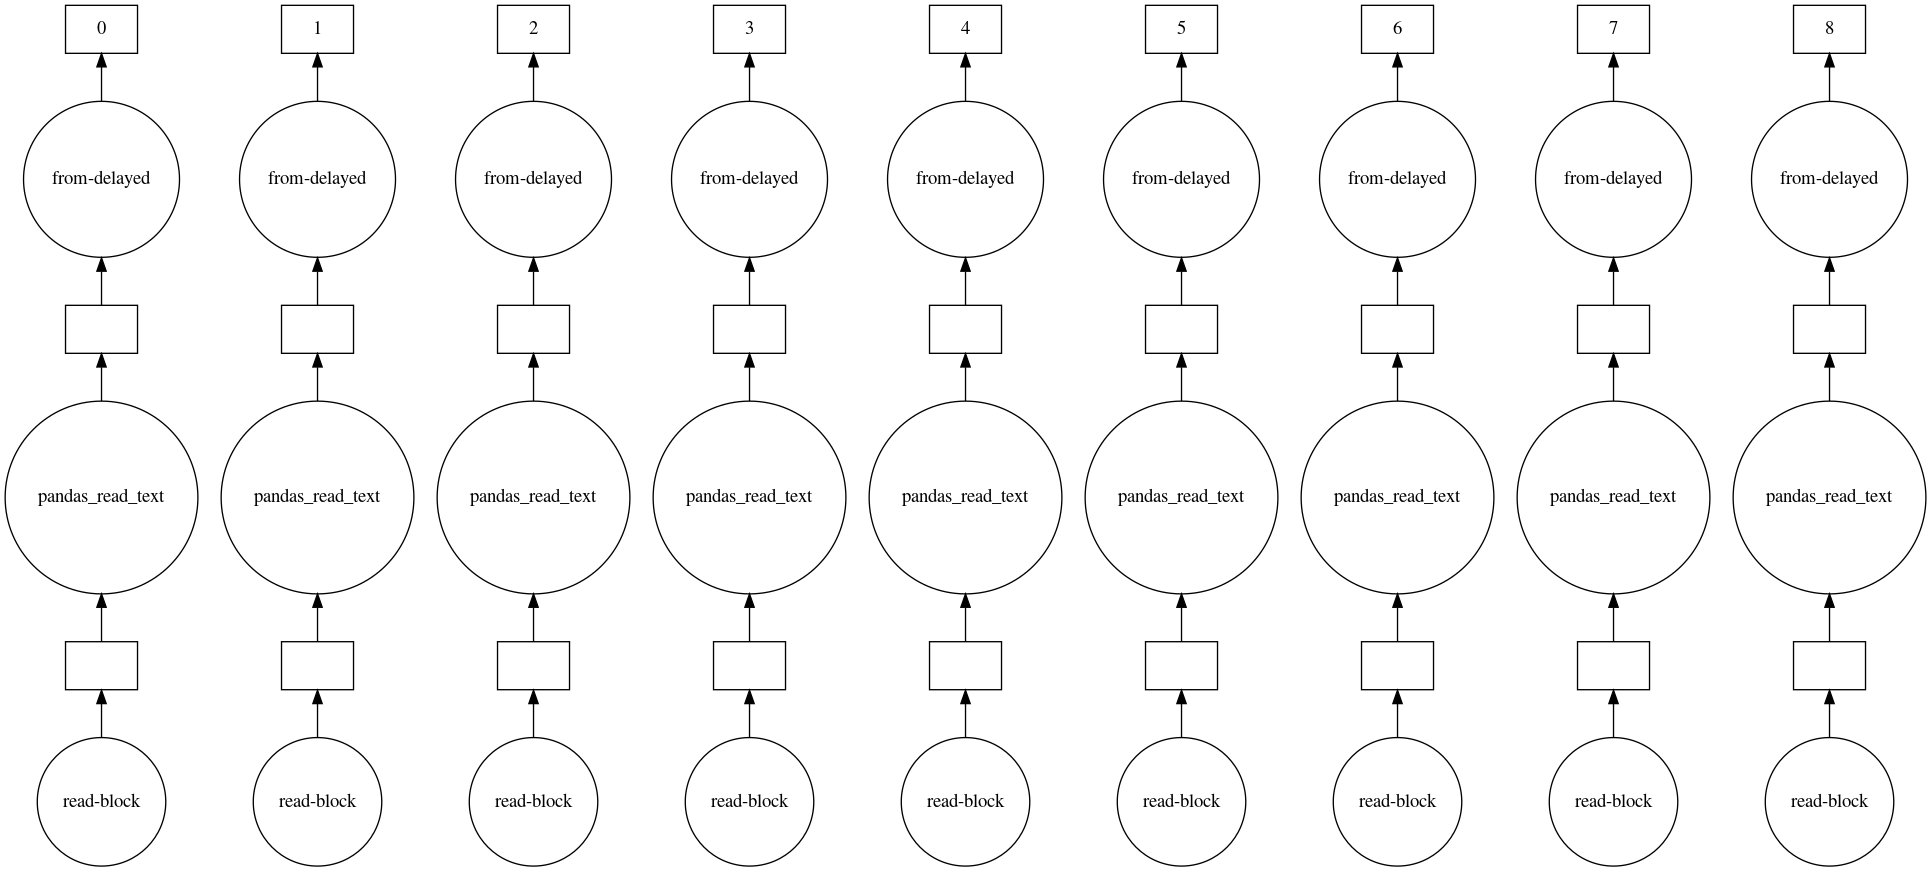

In [80]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_dd = dd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)
# Repartition (more or less partitions) if necessary; toy around with this a bit
# metadata_dd = metadata_dd.repartition(npartitions=metadata_dd.npartitions // 100)
metadata_dd.visualize()

Computations when building the elasticsearch index:<br>
File: `build_research_paper_index.py` <br>
1. `retrieve_paper_body_text` (bunch of file reads and string appending via loops)
2. `remove_papers_with_null_cols` (pandas df mutation)
3. `fill_in_missing_data` (pandas df mutation)
4. `generate_embeddings` (mathematical operations like dot products and sums) <br>
The goal is not to parallelize the computations themselves. What we want to parallelize is its operation on the out-of-memory Dask dataframe. Thus, there will be 4 separate computation graphs, each one having a computation node for each partition of the Dask dataframe. 

In [81]:
%%time

print(f"Num rows before: {metadata_dd.shape[0].compute()}")
relevant_search_cols = [
    "cord_uid", "title", "authors", "abstract", "publish_time", "url", "journal", "pdf_json_files",
]
metadata_dd = metadata_dd[relevant_search_cols]
metadata_dd = metadata_dd.dropna(subset=["title"], how="all")  # remove_papers_with_null_cols
metadata_dd = metadata_dd.dropna(subset=["abstract", "url"], how="all")  # remove_papers_with_null_cols
print(f"Num rows before: {metadata_dd.shape[0].compute()}")
print(f"Null cols before: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")
metadata_dd = metadata_dd.fillna("")  # fill_in_missing_data
print(f"Null cols after: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")

Num rows before: 379974
Num rows before: 328190
Null cols before: ['authors', 'abstract', 'publish_time', 'url', 'journal', 'pdf_json_files']
Null cols after: []
CPU times: user 447 ms, sys: 45.4 ms, total: 493 ms
Wall time: 7.98 s


In [82]:
print(f"Metadata dd shape: {metadata_dd.shape}")  # (Delayed shape, # cols)
print(f"Metadata dd memory usage: {metadata_dd.memory_usage().sum().compute()}")
print(f"Metadata dd types: {metadata_dd.dtypes}")
print(f"Metadata dd # partitions: {metadata_dd.npartitions}")
print(f"Metadata dd index: {metadata_dd.index}")

Metadata dd shape: (Delayed('int-d269bf3c-4a48-4e1e-9173-c8eeb1c0453a'), 8)
Metadata dd memory usage: 23629680
Metadata dd types: cord_uid          object
title             object
authors           object
abstract          object
publish_time      object
url               object
journal           object
pdf_json_files    object
dtype: object
Metadata dd # partitions: 9
Metadata dd index: Dask Index Structure:
npartitions=9
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: fillna, 72 tasks


In [83]:
def retrieve_paper_body_text(pdf_json_files: str) -> str:
    if pdf_json_files and type(pdf_json_files) is str:
        for json_path in pdf_json_files.split("; "):
            paper_body_text = []

            try:
                with open(json_path) as paper_json:
                    full_text_dict = json.load(paper_json)

                    for paragraph_dict in full_text_dict["body_text"]:
                        paragraph_text = paragraph_dict["text"]
                        section_name = paragraph_dict["section"]
                        if section_name.lower() != "abstract":
                            paper_body_text.append(paragraph_text)

                if paper_body_text:  # Stop searching through pdf_json_files
                    return "\n".join(paper_body_text)
            except FileNotFoundError as e:
                print(f"Failed on {json_path} with exception: {str(e)}")

    return ""

def retrieve_paper_body_text_for_series(pdf_json_files_series: pd.Series) -> pd.Series:
    return pdf_json_files_series.apply(lambda pdf_json_files: retrieve_paper_body_text(pdf_json_files))

def generate_embeddings(embedding_type: str, docs: pd.Series) -> pd.Series:
    if embedding_type == "tfidf":
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        doc_embeddings = tfidf_vectorizer.fit_transform(docs)
        print(f"Title embeddings shape: {doc_embeddings.toarray()}")
    else:
        try:
            # TODO: Correctly load and generate embeddings using CORD19 embeddings and HuggingFace transformers lib
            embeddings = DEEP_EMBEDDINGS_MAP[embedding_type]
        except KeyError:
            raise KeyError(
                f"Embedding type {embedding_type} nonexistent in embedding map: {DEEP_EMBEDDINGS_MAP}. Make sure the embedding type exists as a key in the embedding map."
            )

    return doc_embeddings

Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
CPU times: user 46.4 ms, sys: 53.1 ms, total: 99.5 ms
Wall time: 334 ms


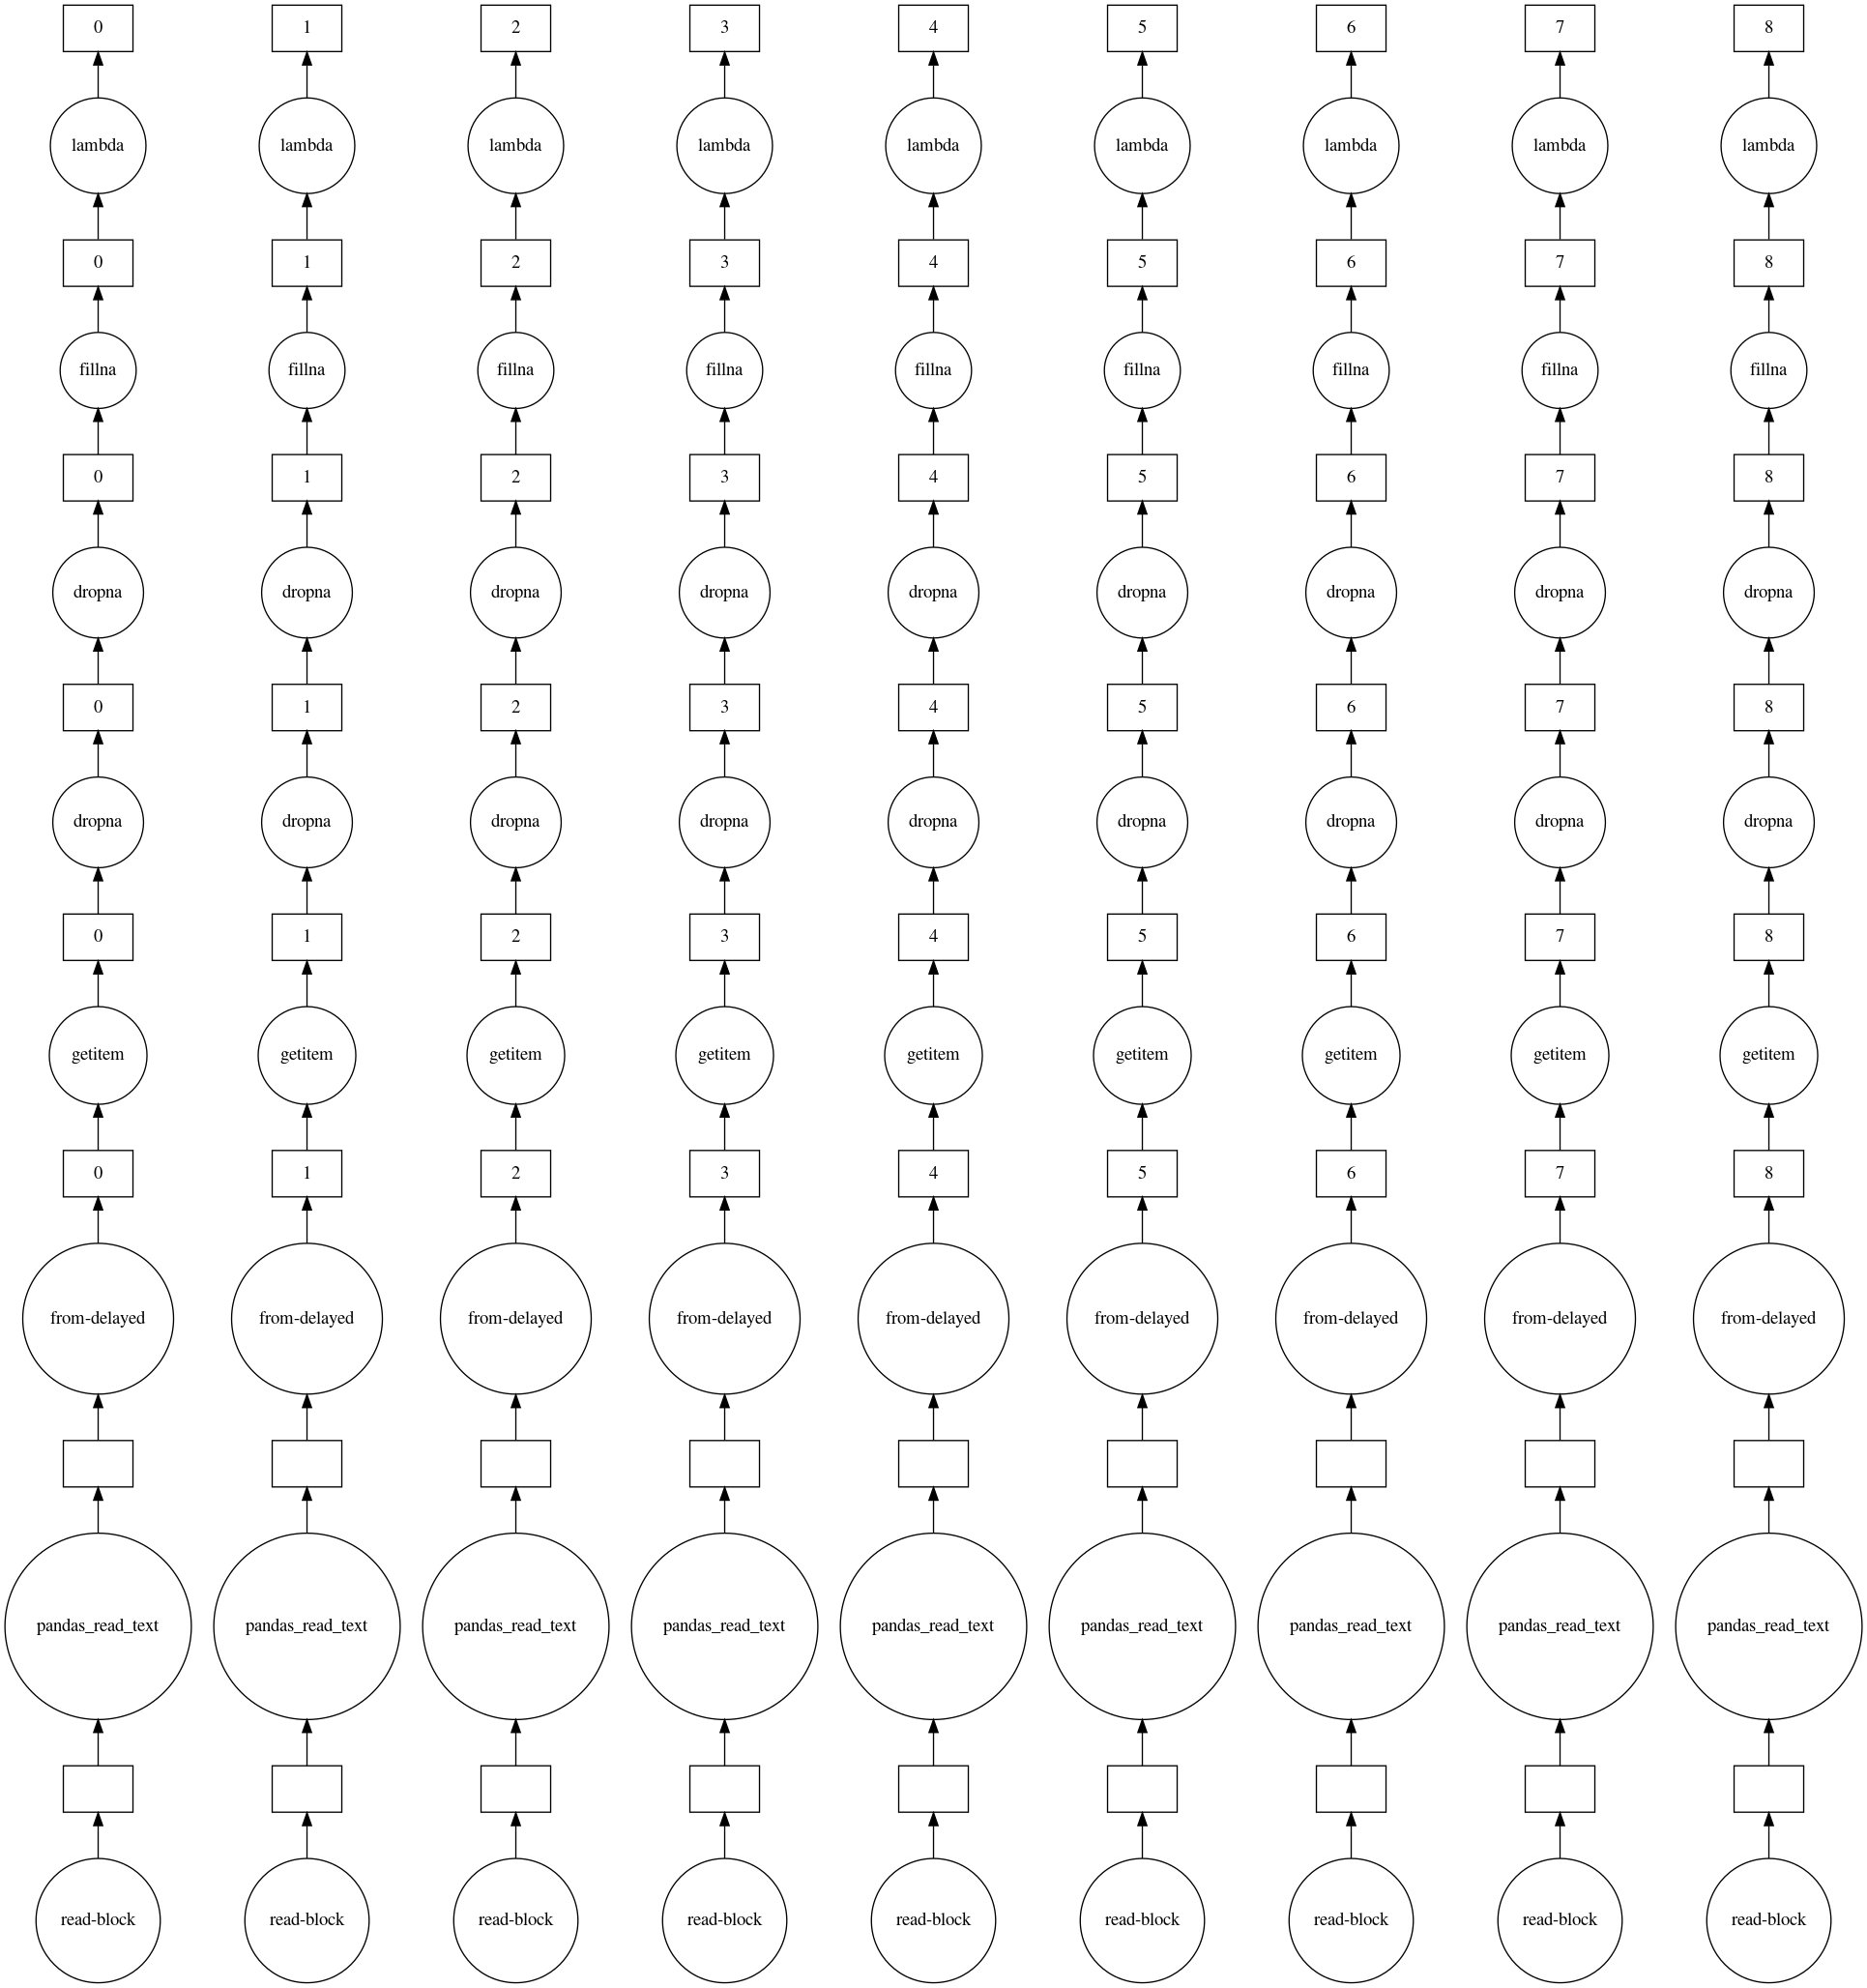

In [84]:
%%time

metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        body=retrieve_paper_body_text_for_series(df.pdf_json_files)
    )
)
"""
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        title_tfidf_embedding=generate_embeddings("tfidf", df.title)
    )
)
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        abstract_tfidf_embedding=generate_embedding("tfidf", df.abstract)
    )
)
"""
metadata_dd.visualize()

Below cell will run into OOM error since compute() function loads the result (in this case, the entire df) into memory. <br>
Thus, we have to figure out a way to keep it as a lazily loaded dask.Dataframe even after transformation. <br> <br>
**Solution 1:**
Maybe for the new cols (body, tf-idf/bert/cord19 embeddings), we create new dask.Dataframes for those. <br>
These new dask.Dataframes should preserve the order, so then we can just do the same operation of:
```
metadata_dd.iloc[start_idx: start_idx+CHUNK_SIZE].compute(), 
body_dd.iloc[start_idx: start_idx+CHUNK_SIZE],
embeddings_dd.iloc[start_idx: start_idx+CHUNK_SIZE].compute()
```
**Solution 2:**
Above solution is stupid. The metadata_dd up until now, as shown in the computation graph above, has all the computations loaded. <br>
Thus, when we chunk the pandas df by a factor of `CHUNK_SIZE=1000` when sending it to the Elasticsearch index, we can simply call compute() on it that time and all the transformations will occur. It will be loaded into memory, BUT only `CHUNK_SIZE` rows at a time (which should definitely be small enough to not lead to OOM error, but confirm my calling `dd.iloc[start_idx:start_idx+CHUNK_SIZE].compute().memory_usage().sum()`).

In [88]:
# Note: Don't want to do this, especially since the whole point of Dask is to never load entire dataframes into memory
# metadata_dd.compute(scheduler="processes")

COVID19_PAPERS_INDEX = "covid19_papers"
DATA_TYPE = "research_paper"
UPLOAD_CHUNK_SIZE = 100

def rec_to_actions(df, index, data_type):
    for record in df.to_dict(orient="records"):
        record_id = record["cord_uid"]
        yield (
            '{ "index" : { "_index" : "%s", "_type" : "%s", "_id": "%s" }}'
            % (index, data_type, record_id)
        )
        yield (json.dumps(record))

def upload_papers_to_es_idx(
    papers_df, es_idx, es_hosts, data_type=DATA_TYPE, chunk_size=UPLOAD_CHUNK_SIZE
):
    """
    Uploading Pandas DF to Elasticsearch Index: https://stackoverflow.com/questions/49726229/how-to-export-pandas-data-to-elasticsearch
    """
    # TODO: Catch other exceptions in the future: https://elasticsearch-py.readthedocs.io/en/master/exceptions.html
    try:
        es = Elasticsearch(hosts=es_hosts)
        es.indices.create(index=es_idx, ignore=400)
    except RequestError:
        print(f"Index {es_idx} already exists; continue uploading papers to {es_idx}")

    try:
        idx = 0
        # num_rows = papers_df.shape[0].compute()
        num_rows = chunk_size
        while idx < num_rows:
            if idx + chunk_size < num_rows:
                max_idx = idx + chunk_size
            else:
                max_idx = num_rows

            start = time.time()
            papers_df_chunk = papers_df.loc[idx:max_idx].compute(scheduler="processes")
            end = time.time()
            print(f"Chunk compute time: {end - start}")
            # print(f"Papers chunk memory size: {papers_df_chunk.memory_usage().sum()}")
            r = es.bulk(rec_to_actions(papers_df_chunk, es_idx, data_type))
            print(f"Uploaded {papers_df_chunk.shape[0]} papers")
            end_2 = time.time()
            print(f"Chunk upload time: {end_2 - end}")
            idx = max_idx
            print(f"Errors: {r['errors']}")
    except TransportError as te:
        transport_error_413_url = "https://github.com/elastic/elasticsearch/issues/2902"
        transport_error_429_urls = [
            "https://stackoverflow.com/questions/61870751/circuit-breaking-exception-parent-data-too-large-data-for-http-request",
            "https://github.com/elastic/elasticsearch/issues/31197",
        ]
        if te.status_code == 413:
            print(
                f"Transport error with status code 413. Chunk size is too large, so try reducing chunk size constant or increase http.max_content_length in the yml file. More info here: {transport_error_413_url}"
            )
        elif te.status_code == 429:
            print(
                f"Transport error with status code 429. Elasticsearch's JVM heap size is too small, so try increasing ES_HEAP_SIZE env var in docker-compose.yml. More info here: {transport_error_429_urls}"
            )
        print(f"Error stacktrace: {te.error, te.info}")
        raise te

In [89]:
%%time

upload_papers_to_es_idx(metadata_dd, COVID19_PAPERS_INDEX, ["localhost"])

Uploading papers from 0 to 1000: 7930


distributed.nanny - WARNING - Restarting worker


Chunk compute time: 328.7277991771698
Transport error with status code 413. Chunk size is too large, so try reducing chunk size constant or increase http.max_content_length in the yml file. More info here: https://github.com/elastic/elasticsearch/issues/2902
Error stacktrace: ('', None)


TransportError: TransportError(413, '')

**Chunk size: 100** <br>
Uploading papers from 0 to 100: 797 <br>
Chunk compute time: 52.8104887008667 <br>
Uploaded papers from 0 to 100 <br>
Chunk upload time: 3.007266044616699 <br>
Errors: False <br>
CPU times: user 4.46 s, sys: 945 ms, total: 5.4 s <br>
Wall time: 1min 47s 

In [77]:
%%time

# 6.5GB total - 46.5 s
metadata_dd.memory_usage(deep=True).sum().compute(scheduler="processes")

CPU times: user 1.95 s, sys: 443 ms, total: 2.39 s
Wall time: 51.3 s


6497706922

In [97]:
metadata_dd.partitions

In [105]:
%%time

metadata_chunk = metadata_dd.loc[0].compute()
metadata_chunk_2 = metadata_dd.loc[0:1000].compute()

CPU times: user 3.9 s, sys: 948 ms, total: 4.85 s
Wall time: 1min 38s


In [106]:
metadata_chunk_2.shape

(7930, 9)

In [104]:
metadata_df[metadata_df["cord_uid"] == "soksrmkx"]
metadata_dd.index.value_counts().compute()

7028     9
2803     9
2679     9
2681     9
2682     9
        ..
52511    1
48189    1
52509    1
52504    1
56991    1
Length: 55820, dtype: int64